# Unsupervised Machine Learning with Fashion-MNIST 

This analysis will apply unsupervised learning techniques, namely K-means and hierarchical clustering to separate the Fashion-MNIST dataset. Dimensionality reduction methods will also be tested to see if they have a positive effect on performance. The objective is to see how effectively these algorithms can cluster the data into its inherent classes, despite the absence of training labels during the learning process.  Since the data includes a target variable, it will be useful to evaluate how well the chosen unsupervised algorithms perform in a clustering task. 

Fashion-MNIST is a popular benchmark dataset in machine learning comprising 70,000 grayscale images of Zalados fashion articles, each sized at 28 * 28 pixels. The images are uniformly distributed across the 10 categories listed below. Although the dataset contains labels, the primary focus is on unsupervised clustering and evaluation of how well these methods approximate the true classes. For more infomation on this dataset, see the [Fashion-MNIST Github page](https://github.com/zalandoresearch/fashion-mnist?tab=readme-ov-file)


The image dataset consits of a trainng set with 60,000 examples and and test set of 10,000 examples. Each training and test example is assigned to one of the following labels:

| Label | Description  |
|-------|--------------|
| 0     | T-shirt/top  |
| 1     | Trouser      |
| 2     | Pullover     |
| 3     | Dress        |
| 4     | Coat         |
| 5     | Sandal       |
| 6     | Shirt        |
| 7     | Sneaker      |
| 8     | Bag          |
| 9     | Ankle boot   |

In [18]:
# Load Libraries 

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import itertools
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

# Dimension reduction
from sklearn.decomposition import PCA as pca1
from sklearn.decomposition import TruncatedSVD

# Clustering 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

# Supervised Machine Learning Classifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier



In [19]:
train_set = pd.read_csv("fashion-mnist_train.csv")
test_set = pd.read_csv("fashion-mnist_test.csv")

# Exploratory Data Analysis 

In [4]:
print("training set dim:", train_set.shape)
print("test set dim:", test_set.shape)

training set dim: (60000, 785)
test set dim: (10000, 785)


In [16]:
train_set.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [17]:
test_set.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [12]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


In [14]:
train_set.describe().mean(axis=1)

count    60000.000000
mean        72.869624
std         69.954243
min          0.000000
25%         14.803185
50%         59.009554
75%        122.174204
max        251.961783
dtype: float64

In [15]:
test_set.describe().mean(axis=1)

count    10000.000000
mean        73.073339
std         70.095393
min          0.000000
25%         14.878662
50%         59.407006
75%        122.617516
max        250.064968
dtype: float64

In [9]:
train_set['label'].value_counts()

2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: label, dtype: int64

In [10]:
test_set['label'].value_counts()

0    1000
1    1000
2    1000
3    1000
8    1000
6    1000
5    1000
4    1000
7    1000
9    1000
Name: label, dtype: int64

In [11]:
X_train = train_set.drop(columns = "label")
y_train = train_set["label"]

X_test = test_set.drop(columns = "label")
y_test = test_set["label"]

# Dimensionality Reduction

With over 60,000 rows and 784 attributes spanning 10 classes, this dataset could significantly slow down the clustering algorithms. Reducing the data's dimensions while preserving its most important features can enhance time effficiency. To achieve this, two dimension reduction methods Principle Componenet Analysis (PCA) and Singular Vector Decomposition (SVD), will be tested to determine if either offers a competitive advantage to K-means or hierarchical  clustering. Spectral clustering will also be tested for comparison.

## 1. Principle Component Analysis (PCA)

In [20]:
# Scale data before applying PCA
scaling=StandardScaler()
 
# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaling.fit_transform(X_train)
X_test_scaled = scaling.transform(X_test)
 
# Set the n_component
principal=pca1(n_components=5)
principal.fit(X_train_scaled)

# Apply the PCA transformation
X_train_pca = principal.transform(X_train_scaled)
X_test_pca = principal.transform(X_test_scaled)

## 2. Singular Value Decomposition (SVD)

Singular Value Decomposition allows any matrix regardless of symmetry, dimension, or rank to be factored into three matrices: 

$$A = U E V^T$$



These three matrices represent a linear transformation that converts the original matrix into a lower-dimensional matrix through a sequence of operations: rotation, stretching, and another rotation. Specifically:

- **Matrix**\( U \): Contains the left singular vectors, responsible for rotating the standard basis.
- **Matrix** \( E \): A diagonal matrix with singular values that stretches the matrix 𝐴
- **Matrix** \( V^T \): Contains the right singular vectors that rotate the matrix back to the standard basis.



In [36]:
# Flatten the images
x_train_flat = np.array(X_train).reshape(X_train.shape[0], -1)
x_test_flat = np.array(X_test).reshape(X_test.shape[0], -1)

# Normalize the data
x_train_flat = x_train_flat.astype('float32') / 255.0
x_test_flat = x_test_flat.astype('float32') / 255.0

# Step 2: Apply SVD to reduce dimensionality
n_components = 5  # Number of components to keep
svd = TruncatedSVD(n_components=n_components)
x_train_svd = svd.fit_transform(x_train_flat)
x_test_svd = svd.transform(x_test_flat)


# Hierarchical Clustering 

**Hierarchical clustering** is a techinique that builds nested clusters of data points using similarity or distance metrics. The algorithm recursively merges pairs of clusters of sample data based on thier linkage distance. This process is deterministic, meaning it is reproducible and does not require setting a random seed. 
 

Agglomerative clustering is a "bottom up" approach. The algorithm starts with each observation as its own cluster, and the clusters are merged one as one moves up the hierarchy. The calculations begin with a distance matrix which identifies the initial observations that are closest to each other. These two observations become the first cluster. The algorithm then we successively calculates the distance of each remaining point to the the initial cluster and merges the point that is closest. 
 
 
The hierarchy of clusters is represented as a **dendogram** or a tree, which visually to shows the relationships between the samples. While the number of clusters can be specified, it is not necessary. Visualizing the resulting tree is useful to understand the structure of the data and ultimatly provides cues for where to cut the tree to find the number of clusters. 

**Linkage methods** determine how distances between specific pairs of points within clusters are calculated during the merging process. These methods include: 

| **Linkage** | **Calculation**                        | **Description**                                                                 |
|-------------|----------------------------------------|---------------------------------------------------------------------------------|
| **Complete** | `dist(max)`                             | Minimizes the maximum distance between observations of pairs of clusters.        |
| **Single**   | `dist(min)`                             | Minimizes the distance between the closest observations of pairs of clusters.    |
| **Average**  | `(dist(max) + dist(min)) / n`           | Minimizes the average of the distances between all observations of pairs of clusters. |
| **Centroid** | `dist(C_a, C_b) / n`                    | Minimizes the distance between the centroids of the clusters being merged.       |
| **Ward**     | `dist(min variance)`                    | Minimizes the sum of squared differences within all clusters.                    |

 
 **Similarity or distance metrics** used in hierarchical clustering can vary depending on the data and the specific goals of the analysis. Common metric include: 
 - Euclidean 
 - Manhattan 
 - cosine 
 - L1
 - L2 
 
 
Each of these metrics can influence the shape and structure of the resulting clusters, and the choice of metric should align with the nature of the data and the research question being addressed.


In [32]:

def find_best_permutation(y_true, y_pred, n_classes = 10):
    """
    ytdf: Ground truth labels (numeric form)
    yp: Predicted clustering labels
    Returns the best label permutation using the Hungarian algorithm and its accuracy.
    """
   # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    
    # Apply the Hungarian algorithm to find the best permutation
    row_ind, col_ind = linear_sum_assignment(-cm)
    
    best_permutation = col_ind
    best_accuracy = cm[row_ind, col_ind].sum() / len(y_true)
    
    return tuple(best_permutation), round(best_accuracy, 3)


def hierarchical_clustering(X_test, y_true, n_clusters):  #training/predictor variables, target variables 

    linkages = ['complete', 'average', 'single', 'ward']
    dist_metrics =  ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']


    results = []
    
    for link in linkages:
    
        if link == 'ward':
            dist_metrics_to_use = ['euclidean']  # Ward linkage is only compatible with Euclidean distance
        else:
            dist_metrics_to_use = dist_metrics
        
        for metric in dist_metrics_to_use: 
        
           # Initialize  and fit the model 
            model = AgglomerativeClustering(n_clusters = n_clusters, metric= metric, linkage = link)
            model = model.fit(X_test)
            
            # Predict clusters on the training data and use them to predict the test data
            y_test_pred = model.labels_
            
        # Compute accuracy using the best permutation
            labelorder, acc = find_best_permutation(y_true, y_test_pred, n_classes=n_clusters)
            y_test_pred = [labelorder[l] if l < n_clusters else -1 for l in y_test_pred]
        
            accuracy = accuracy_score(y_true, y_test_pred)
        
        # Store results 
            results.append({
                'linkage': link,
                'distance_metric': metric,
                'accuracy': accuracy 
                })
        
    return pd.DataFrame(results)       


In [33]:
# CLustering after PCA 
results_pca = hierarchical_clustering(X_test_pca, y_test, 10)


In [35]:
results_pca

,linkage,distance_metric,accuracy
0,complete,euclidean,0.2468
1,complete,l1,0.0964
2,complete,l2,0.2468
3,complete,manhattan,0.0964
4,complete,cosine,0.0476
5,average,euclidean,0.2074
6,average,l1,0.2087
7,average,l2,0.2074
8,average,manhattan,0.2087
9,average,cosine,0.1056


In [26]:
# clustering after SVD 
results_svd = hierarchical_clustering(x_test_svd, y_test, n_clusters = 10)

In [27]:
results_svd

,linkage,distance_metric,accuracy
0,complete,euclidean,0.0383
1,complete,l1,0.1886
2,complete,l2,0.0383
3,complete,manhattan,0.1886
4,complete,cosine,0.1146
5,average,euclidean,0.1439
6,average,l1,0.2898
7,average,l2,0.1439
8,average,manhattan,0.2898
9,average,cosine,0.1462


# K-means Clustering
        

The K-means algorithm partitions n observations into K clusters, where each observationis assigned to the cluster with the nearest mean. The goal is to minimize the within-cluster variance, calculated as the sum of squared Euclidean distances.

Steps:
1. **Initialization:** Randomly generate K initial means (centroids) within the data.
2. **Assignment:** Calculate the distance between each observation and the centroids, then assign each observation to the nearest cluster.
3. **Update:** Re-calculate the centroid of each cluster as the mean of the observations assigned to it
4. **Iteration:** Repeat the assignment and update steps until the centroids no longer change significantly, indicating convergence.

  

In [9]:
def cluster_data(X_train, X_test, n_clusters):
    # Fit K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train)
    y_pred = kmeans.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=range(n_clusters))
    row_ind, col_ind = linear_sum_assignment(-cm)
    
    permuted_labels = np.zeros_like(y_pred)
    for i, j in zip(row_ind, col_ind):
        permuted_labels[y_pred == j] = i
    
    accuracy = np.mean(permuted_labels == y_test)
    
    return accuracy, permuted_labels, row_ind, col_ind


def plot_clusters_side_by_side(X, labels1, labels2, title1, title2):
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    scatter1 = plt.scatter(X[:, 0], X[:, 1], c=labels1, cmap='tab10', marker='o', edgecolor='k', alpha=0.7)
    plt.colorbar(scatter1, label='Cluster Label')
    plt.title(title1)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(X[:, 0], X[:, 1], c=labels2, cmap='tab10', marker='o', edgecolor='k', alpha=0.7)
    plt.colorbar(scatter2, label='True Label')
    plt.title(title2)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    plt.tight_layout()
    plt.show()

In [10]:

# Cluster data using K_means
n_clusters = 10 


# Find best permutation and accuracy
accuracy, permuted_labels, row_ind, col_ind = cluster_data(x_train_flat, x_test_flat, n_clusters)
accuracy_svd, permuted_labels_svd, row_ind_svd, col_ind_svd = cluster_data(x_train_svd, x_test_svd,  n_clusters)
accuracy_pca, permuted_labels_pca, row_ind_pca, col_ind_pca = cluster_data(X_train_pca, X_test_pca, n_clusters)

print(f'Best accuracy - no transformation: {accuracy:.2f}')
print(f'Best accuracy SVD: {accuracy_svd:.2f}')
print(f'Best accuracy PCA: {accuracy_pca:.2f}')

C:\Users\Julia\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Julia\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Julia\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best accuracy - no transformation: 0.54
Best accuracy SVD: 0.49
Best accuracy PCA: 0.47


In [ ]:
# Step 3: Evaluate the clustering
print("Confusion Matrix:")
print(confusion_matrix(y_test, permuted_labels))
print("\nClassification Report:")
print(classification_report(y_test, permuted_labels))

In [ ]:
# Step 3: Evaluate the clustering
print("Confusion Matrix:")
print(confusion_matrix(y_test, permuted_labels_svd))
print("\nClassification Report:")
print(classification_report(y_test, permuted_labels_svd))

In [ ]:
# Step 3: Evaluate the clustering
print("Confusion Matrix:")
print(confusion_matrix(y_test, permuted_labels_pca))
print("\nClassification Report:")
print(classification_report(y_test, permuted_labels_pca))

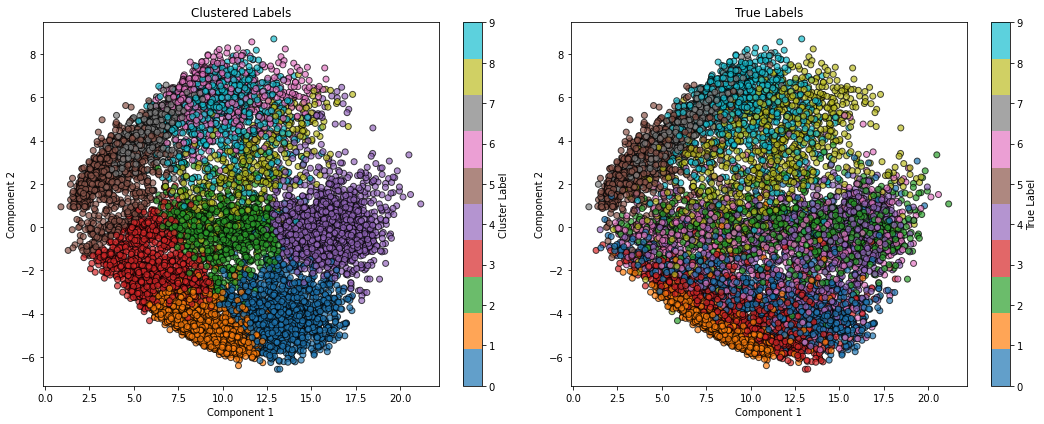

In [11]:
# Plot clusters side by side
plot_clusters_side_by_side(x_test_svd, permuted_labels_svd, y_test, "Clustered Labels", "True Labels")

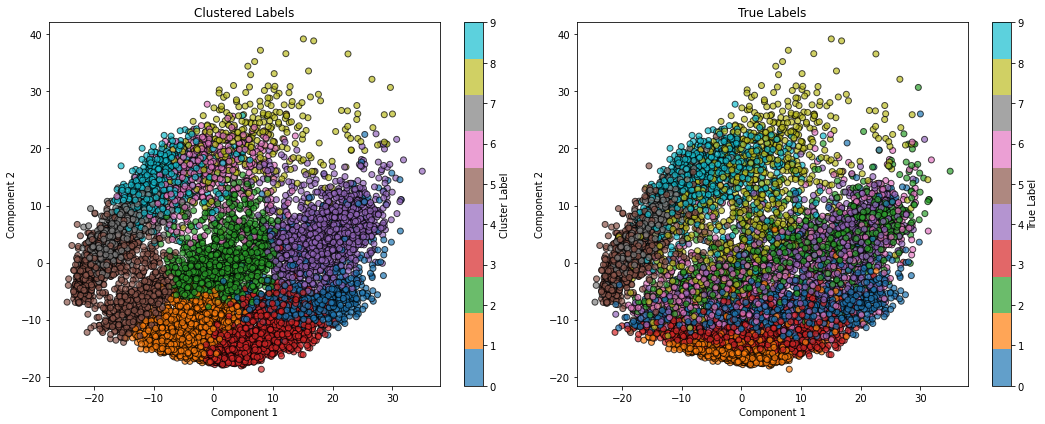

In [13]:
# Plot clusters side by side
plot_clusters_side_by_side(X_test_pca, permuted_labels_pca, y_test, "Clustered Labels", "True Labels")

# Spectral Clustering 

Spectral clustering is a technique used to perform low-dimensional embedding of the affinity matrix between samples, followed by clustering—typically using K-means—on the components of the eigenvectors in the lower-dimensional space. This method is particularly efficient when the affinity matrix is sparse, and the algebraic multigrid (AMG) solver is used for solving the eigenvalue problem.

These are the basic steps:

1. **Start with the Affinity Matrix (A):** This matrix represents the similarity between objects. In a graph, it indicates whether an edge exists between points.
2. **Compute the Degree Matrix (D):** A diagonal matrix where entry (i, i) equals the number of objects similar to object i 
3. **Calculate the Laplacian Matrix (L):** Defined as $$L =A - D $$
4. **Find Eigenvectors:** Extract the top k eigenvectors of the Laplacian matrix based on their eigenvalues.
5. **Cluster the Eigenvectors:** Apply K-means to cluster the objects into k classes based on the eigenvectors.

In [30]:
# import required functions and libraries
from sklearn.datasets import make_circles
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
import numpy as np
import matplotlib.pyplot as plt


# plot your data
#plt.scatter(X[:, 0], X[:, 1])
#plt.show()

# train and predict
def spetral_clustering(X_test, y_test, n_clusters): 
    
    spectral = SpectralClustering(n_clusters = 10, eigen_solver='arpack', affinity="nearest_neighbors")

    y_pred = spectral.fit_predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=range(n_clusters))
    row_ind, col_ind = linear_sum_assignment(-cm)
    
    permuted_labels = np.zeros_like(y_pred)
    for i, j in zip(row_ind, col_ind):
        permuted_labels[y_pred == j] = i
    
    accuracy = np.mean(permuted_labels == y_test)
    
    return accuracy, permuted_labels, row_ind, col_ind
        


In [31]:
accuracy, permuted_labels, row_ind, col_ind = spetral_clustering(x_test_flat, y_test, n_clusters = 10)

print(f'Best accuracy spectral clustering: {accuracy:.2f}')


Best accuracy spectral clustering: 0.53


In [34]:
# Step 3: Evaluate the clustering
print("Confusion Matrix:")
print(confusion_matrix(y_test, permuted_labels))
print("\nClassification Report:")
print(classification_report(y_test, permuted_labels))

Confusion Matrix:
[[567   0  50 128   5   0 245   1   4   0]
 [  0 908  21  45   0   0  26   0   0   0]
 [  6   0 728  12   4   0 250   0   0   0]
 [ 15   7  24 848   0   0 106   0   0   0]
 [  1   0 720 159   1   0 117   0   2   0]
 [  0   0   0   0   3  38 332 518   0 109]
 [147   0 364  95   9   0 384   0   1   0]
 [  0   0   0   0   0   3   4 751   0 242]
 [  0   1  66   2 358   0  72  23 475   3]
 [  0   0   0   0   1 401  16  12   0 570]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.57      0.65      1000
           1       0.99      0.91      0.95      1000
           2       0.37      0.73      0.49      1000
           3       0.66      0.85      0.74      1000
           4       0.00      0.00      0.00      1000
           5       0.09      0.04      0.05      1000
           6       0.25      0.38      0.30      1000
           7       0.58      0.75      0.65      1000
           8       0.99      0.47      0

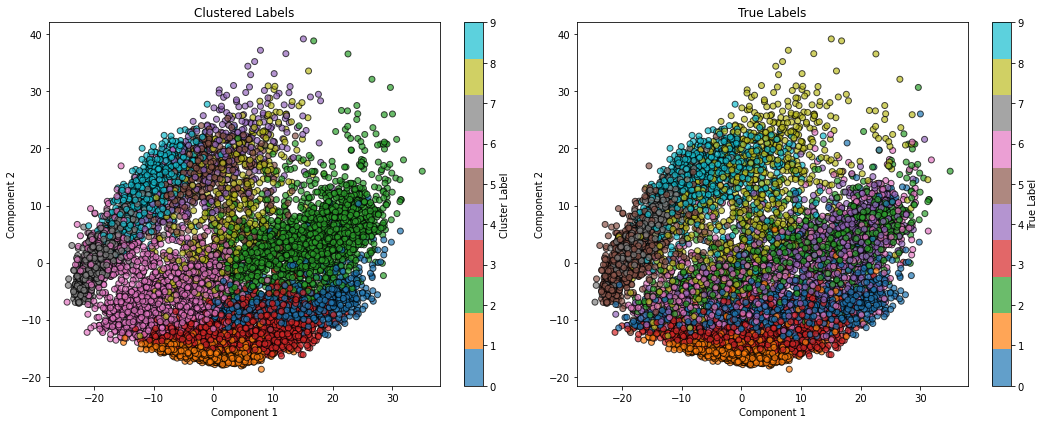

In [32]:
plot_clusters_side_by_side(X_test_pca, permuted_labels, y_test, "Clustered Labels", "True Labels")

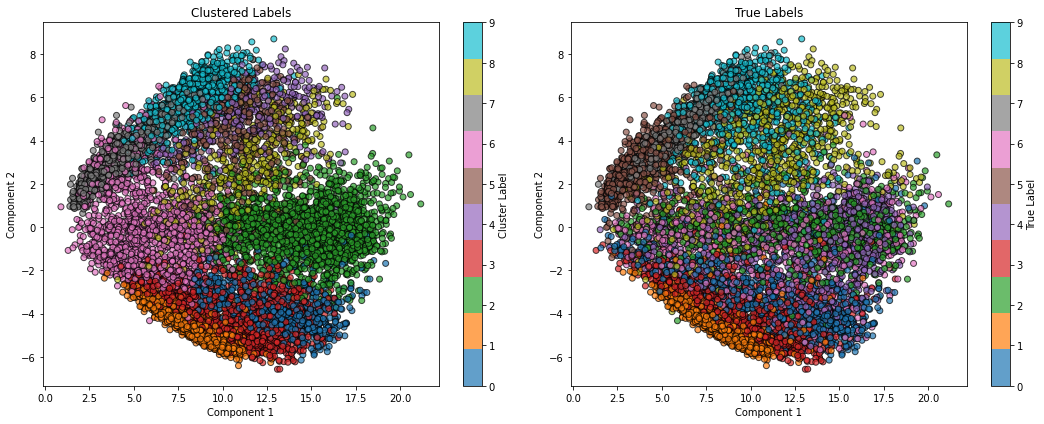

In [33]:
plot_clusters_side_by_side(x_test_svd, permuted_labels, y_test, "Clustered Labels", "True Labels")

# Supervised Algorithms 

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    GradientBoostingClassifier(random_state=0),
    LogisticRegression(max_iter=1000, random_state=0),
    SVC(random_state=0, probability=True)  # Added probability=True for compatibility with cross_val_score scoring
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [43]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
GradientBoostingClassifier,0.8584,0.006025
LogisticRegression,0.7676,0.007797
RandomForestClassifier,0.7673,0.007743
SVC,0.8595,0.005624


In [ ]:
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

# Analysis of Clustering Results on Fashion-MNIST

### Dimensionality Reduction and Visualization:

Upon reducing the dimensionality of the Fashion-MNIST dataset, we observed distinct patterns in how various classes are represented. Classes such as 0 (T-shirt/top), 1 (Trouser), 2 (Pullover), 7 (Sneaker), and 8 (Bag) are clearly separable in the lower-dimensional space. However, classes 5 (Coat) and 6 (Sandal) exhibit significant overlap, making them challenging to distinguish from one another. This indicates that these classes are inherently less separable in the feature space, even after dimensionality reduction.

### Performance of Clustering Algorithms:

**Hierarchical Clustering:**
Hierarchical clustering models had the poorest perfomance. Applying the Hungarian algorithm to find the best permutation improved the results but not to accuacry score that would be considered good performance. Hierarchical clustering with Singular Value Decomposition (SVD) yielded an accuracy of 0.28 which was slighly better than hierarchical clustering with Principal Component Analysis (PCA) with accuracy score of 0.24.

**K-Means Clustering:**
Applying K-means clustering with Singular Value Decomposition (SVD) yielded an accuracy of 0.54. This result was slightly better than spectral clustering, which achieved an accuracy of 0.53. Interestingly, when Principal Component Analysis (PCA) was used prior to K-means clustering, the accuracy was the lowest among the methods tested (0.47).

**Spectral Clustering:**
Spectral clustering demonstrated a notable ability to produce cluster labels that closely matched the structure of the actual data. This observation held true whether the data was projected onto lower dimensions using PCA or SVD methods. The spectral clustering approach effectively captured the intrinsic structure of the data, leading to relatively accurate clustering results.

**Conclusion:**

Overall, unsupervised algorithms struggled to achieve high performance in separating the Fashion-MNIST data into distinct classes. While spectral clustering showed promise in reflecting the underlying structure of the data, the clustering algorithms in general did not perform well in distinguishing the classes. Supervised algorithms significantly outperformed clustering techniques in separating the data into it's inherent classes, owing to direct supervision that helps the model learn clear patterns and relationships between inputs and outputs, leading to more accurate predictions. The challenges with separating similar classes and the inefficiency of some algorithms highlight the complexity of clustering high-dimensional image data.